# Load

In [1]:
!pip install xgboost

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 253.9/253.9 MB 1.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 291.7/291.7 MB 1.4 MB/s eta 0:00:00


In [2]:
import pandas as pd
import numpy as np
import gc

import xgboost as xgb
from sklearn.preprocessing import LabelEncoder

In [3]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [4]:
df=pd.read_csv(r'/content/drive/MyDrive/open/iM_데이콘_유사컬럼.csv')

In [5]:
# 'Unnamed: 0' 컬럼 제거
df.drop(columns=['Unnamed: 0'], inplace=True)

# 결과 확인
print(df.columns)


Index(['기준년월', 'ID', '_1순위업종', '총이용건수', '총이용금액', '연령', '남녀구분코드', 'Segment',
       '거주시도명', '월평균잔액', '최종카드론_대출금액'],
      dtype='object')


In [6]:
# 고객등급 값의 비율 계산 (normalize=True → 비율)
grade_ratio = df['Segment'].value_counts(normalize=True, dropna=False)

# 백분율로 보기 좋게 정리
grade_ratio = (grade_ratio * 100).round(2)

# 출력
print("📊 Segment 분포 비율 (%):")
print(grade_ratio)


📊 Segment 분포 비율 (%):
Segment
E    80.09
D    14.55
C     5.32
A     0.04
B     0.01
Name: proportion, dtype: float64


# EDA

In [ ]:
df.head(5)

,기준년월,ID,_1순위업종,총이용건수,총이용금액,연령,남녀구분코드,Segment,거주시도명,월평균잔액,최종카드론_대출금액
0,201807,TRAIN_000000,납부,11,14204,40대,2,D,서울,17237,0
1,201807,TRAIN_000001,쇼핑,13,2862,30대,1,E,경기,7967,76723
2,201807,TRAIN_000002,쇼핑,12,20160,30대,1,C,서울,59917,95094
3,201807,TRAIN_000003,쇼핑,6,14176,40대,2,D,부산,27854,0
4,201807,TRAIN_000004,NaN,-2,0,40대,2,E,광주,0,0


In [ ]:
df['연령'].unique()

array(['40대', '30대', '20대', '60대', '50대', '70대이상'], dtype=object)

In [ ]:
# 회원정보[month] - 기준년월, ID, 연령, 남녀구분코드, Segment, 거주시도명
# 승인매출정보[month] - _1순위업종, 총이용건수, 총이용금액, 최종카드론_대출금액
# 잔액정보[month] - 월평균잔액

In [ ]:
cols = ['기준년월', 'ID', '_1순위업종', '총이용건수', '총이용금액',
        '연령', '남녀구분코드', 'Segment', '거주시도명',
        '월평균잔액', '최종카드론_대출금액']

In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2400000 entries, 0 to 2399999
Data columns (total 11 columns):
 #   Column      Dtype 
---  ------      ----- 
 0   기준년월        int64 
 1   ID          object
 2   _1순위업종      object
 3   총이용건수       int64 
 4   총이용금액       int64 
 5   연령          object
 6   남녀구분코드      int64 
 7   Segment     object
 8   거주시도명       object
 9   월평균잔액       int64 
 10  최종카드론_대출금액  int64 
dtypes: int64(6), object(5)
memory usage: 201.4+ MB


# 칼럼 수정

In [ ]:
df.rename(columns={
    '기준년월': '거래년월',
    'ID':'고객ID',
    '총이용건수':'승인건수',
    '총이용금액':'승인금액',
    '연령': '연령대',
    'Segment':'고객등급',
    '월평균잔액':'수신_요구불예금',
    '최종카드론_대출금액':'대출금액'

}, inplace=True)

In [ ]:
df.head(5)

,거래년월,고객ID,_1순위업종,승인건수,승인금액,연령대,남녀구분코드,고객등급,거주시도명,수신_요구불예금,대출금액
0,201807,TRAIN_000000,납부,11,14204,40대,2,D,서울,17237,0
1,201807,TRAIN_000001,쇼핑,13,2862,30대,1,E,경기,7967,76723
2,201807,TRAIN_000002,쇼핑,12,20160,30대,1,C,서울,59917,95094
3,201807,TRAIN_000003,쇼핑,6,14176,40대,2,D,부산,27854,0
4,201807,TRAIN_000004,NaN,-2,0,40대,2,E,광주,0,0


# 칼럼 제거

In [ ]:
# '_1순위업종' 컬럼 제거
df.drop(columns=['_1순위업종'], inplace=True)
# 결과 확인
print(df.columns)

Index(['거래년월', '고객ID', '승인건수', '승인금액', '연령대', '남녀구분코드', '고객등급', '거주시도명',
       '수신_요구불예금', '대출금액'],
      dtype='object')


In [ ]:
df.head(5)

,거래년월,고객ID,승인건수,승인금액,연령대,남녀구분코드,고객등급,거주시도명,수신_요구불예금,대출금액
0,201807,TRAIN_000000,11,14204,40대,2,D,서울,17237,0
1,201807,TRAIN_000001,13,2862,30대,1,E,경기,7967,76723
2,201807,TRAIN_000002,12,20160,30대,1,C,서울,59917,95094
3,201807,TRAIN_000003,6,14176,40대,2,D,부산,27854,0
4,201807,TRAIN_000004,-2,0,40대,2,E,광주,0,0


# 칼럼 값 범주화

In [ ]:
def categorize_usage(x):
    if x < 0:
        return '거래취소'
    elif x <= 5:
        return '5번이하'
    elif x <= 10:
        return '5번초과 10번이하'
    elif x <= 15:
        return '10번초과 15번이하'
    elif x <= 20:
        return '15번초과 20번이하'
    else:
        return '20번 초과'

# 적용
df['승인건수'] = df['승인건수'].apply(categorize_usage)

# 결과 확인
print(df['승인건수'].value_counts())


승인건수
20번 초과         762352
5번이하           656502
거래취소           396514
5번초과 10번이하     246448
10번초과 15번이하    186666
15번초과 20번이하    151518
Name: count, dtype: int64


In [ ]:
df.head(5)

,거래년월,고객ID,승인건수,승인금액,연령대,남녀구분코드,고객등급,수신_요구불예금,대출금액,거주시도명_경기,...,거주시도명_대전,거주시도명_부산,거주시도명_서울,거주시도명_울산,거주시도명_인천,거주시도명_전남,거주시도명_전북,거주시도명_제주,거주시도명_충남,거주시도명_충북
0,2018-07-01,TRAIN_000000,2,14204,3,2,3,17237,0,False,...,False,False,True,False,False,False,False,False,False,False
1,2018-07-01,TRAIN_000001,2,2862,2,1,4,7967,76723,True,...,False,False,False,False,False,False,False,False,False,False
2,2018-07-01,TRAIN_000002,2,20160,2,1,2,59917,95094,False,...,False,False,True,False,False,False,False,False,False,False
3,2018-07-01,TRAIN_000003,1,14176,3,2,3,27854,0,False,...,False,True,False,False,False,False,False,False,False,False
4,2018-07-01,TRAIN_000004,5,0,3,2,4,0,0,False,...,False,False,False,False,False,False,False,False,False,False


In [ ]:
df['승인건수'].unique()

array(['10번초과 15번이하', '5번초과 10번이하', '거래취소', '5번이하', '20번초과',
       '15번초과 20번이하'], dtype=object)

In [ ]:
df['연령대'].unique()

array(['40대', '30대', '20대', '60대', '50대', '70대이상'], dtype=object)

# 연령대 수정

In [ ]:
df['연령대'] = df['연령대'].replace({'60대': '60대이상', '70대이상': '60대이상'})

# datetime 형변환

In [ ]:
# '거래년월'을 문자열로 변환한 뒤 datetime 처리
df['거래년월'] = pd.to_datetime(df['거래년월'].astype(str), format='%Y%m')

# 라벨 인코딩

In [ ]:
# 승인건수 지정 인코딩
usage_map = {
    '5번이하': 0,
    '5번초과 10번이하': 1,
    '10번초과 15번이하': 2,
    '15번초과 20번이하': 3,
    '20번 초과': 4,
    '거래취소': 5
}
df['승인건수'] = df['승인건수'].map(usage_map)

# 연령대 지정 인코딩
age_map = {
    '20대': 1,
    '30대': 2,
    '40대': 3,
    '50대': 4,
    '60대이상': 5,
}
df['연령대'] = df['연령대'].map(age_map)

# 고객등급 지정 인코딩
grade_map = {
    'A': 0,
    'B': 1,
    'C': 2,
    'D': 3,
    'E': 4
}
df['고객등급'] = df['고객등급'].map(grade_map)


In [ ]:
print(df[['승인건수', '연령대', '고객등급']].head())

   승인건수  연령대  고객등급
0     2    3     3
1     2    2     4
2     2    2     2
3     1    3     3
4     5    3     4


# 원핫 인코딩

In [ ]:
onehot_cols = ['거주시도명']

df = pd.get_dummies(df, columns=onehot_cols, drop_first=True)

In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2400000 entries, 0 to 2399999
Data columns (total 24 columns):
 #   Column    Dtype         
---  ------    -----         
 0   거래년월      datetime64[ns]
 1   고객ID      object        
 2   승인건수      int64         
 3   승인금액      int64         
 4   연령대       int64         
 5   남녀구분코드    int64         
 6   고객등급      int64         
 7   수신_요구불예금  int64         
 8   대출금액      int64         
 9   거주시도명_경기  bool          
 10  거주시도명_경남  bool          
 11  거주시도명_경북  bool          
 12  거주시도명_광주  bool          
 13  거주시도명_대구  bool          
 14  거주시도명_대전  bool          
 15  거주시도명_부산  bool          
 16  거주시도명_서울  bool          
 17  거주시도명_울산  bool          
 18  거주시도명_인천  bool          
 19  거주시도명_전남  bool          
 20  거주시도명_전북  bool          
 21  거주시도명_제주  bool          
 22  거주시도명_충남  bool          
 23  거주시도명_충북  bool          
dtypes: bool(15), datetime64[ns](1), int64(7), object(1)
memory usage: 199.1+ MB


In [ ]:
# '거주시도명_세종' 컬럼 제거
df.drop(columns=['거주시도명_세종'], inplace=True)
# 결과 확인
print(df.columns)

Index(['거래년월', '고객ID', '승인건수', '승인금액', '연령대', '남녀구분코드', '고객등급', '수신_요구불예금',
       '대출금액', '거주시도명_경기', '거주시도명_경남', '거주시도명_경북', '거주시도명_광주', '거주시도명_대구',
       '거주시도명_대전', '거주시도명_부산', '거주시도명_서울', '거주시도명_울산', '거주시도명_인천', '거주시도명_전남',
       '거주시도명_전북', '거주시도명_제주', '거주시도명_충남', '거주시도명_충북'],
      dtype='object')


In [ ]:
# 컬럼별 결측값 개수 출력
missing_count = df.isnull().sum()
missing_count = missing_count.sort_values(ascending=False)  # 결측치 많은 순으로 정렬
print(missing_count)


거래년월        0
고객ID        0
승인건수        0
승인금액        0
연령대         0
남녀구분코드      0
고객등급        0
수신_요구불예금    0
대출금액        0
거주시도명_경기    0
거주시도명_경남    0
거주시도명_경북    0
거주시도명_광주    0
거주시도명_대구    0
거주시도명_대전    0
거주시도명_부산    0
거주시도명_서울    0
거주시도명_울산    0
거주시도명_인천    0
거주시도명_전남    0
거주시도명_전북    0
거주시도명_제주    0
거주시도명_충남    0
거주시도명_충북    0
dtype: int64


In [ ]:
df.to_csv('/content/drive/MyDrive/open/데이콘전처리.csv', index=False)

# 저장한 파일 불러오기

In [ ]:
import numpy as np
import pandas as pd
import seaborn as sns

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [7]:
df=pd.read_csv('/content/drive/MyDrive/open/데이콘전처리.csv', encoding='utf-8-sig')

In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2400000 entries, 0 to 2399999
Data columns (total 24 columns):
 #   Column    Dtype 
---  ------    ----- 
 0   거래년월      object
 1   고객ID      object
 2   승인건수      int64 
 3   승인금액      int64 
 4   연령대       int64 
 5   남녀구분코드    int64 
 6   고객등급      int64 
 7   수신_요구불예금  int64 
 8   대출금액      int64 
 9   거주시도명_경기  bool  
 10  거주시도명_경남  bool  
 11  거주시도명_경북  bool  
 12  거주시도명_광주  bool  
 13  거주시도명_대구  bool  
 14  거주시도명_대전  bool  
 15  거주시도명_부산  bool  
 16  거주시도명_서울  bool  
 17  거주시도명_울산  bool  
 18  거주시도명_인천  bool  
 19  거주시도명_전남  bool  
 20  거주시도명_전북  bool  
 21  거주시도명_제주  bool  
 22  거주시도명_충남  bool  
 23  거주시도명_충북  bool  
dtypes: bool(15), int64(7), object(2)
memory usage: 199.1+ MB


In [ ]:
# 고객등급 비율 (%) 확인
grade_ratio = df['고객등급'].value_counts(normalize=True) * 100
print(grade_ratio.sort_index())  # 등급 순으로 정렬하려면 sort_index()


고객등급
0    0.04
1    0.01
2    5.32
3   14.55
4   80.09
Name: proportion, dtype: float64


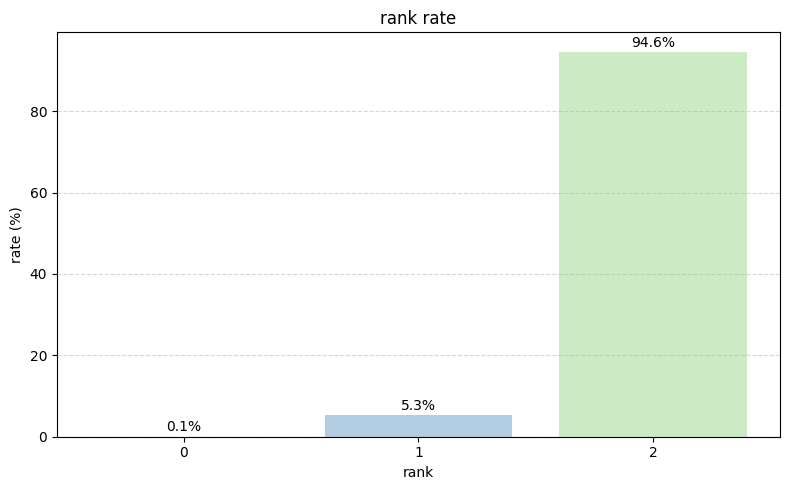

In [9]:
import matplotlib.pyplot as plt
import pandas as pd

# 5단계 등급 → 3단계로 리매핑
def remap_grades(preds):
    return pd.Series(preds).map(lambda x: 0 if x in [0, 1] else 1 if x == 2 else 2)

# 등급 리매핑 적용
df['고객등급_리매핑'] = remap_grades(df['고객등급'])

# 리매핑된 등급 비율 계산
grade_ratio = df['고객등급_리매핑'].value_counts(normalize=True, dropna=False)
grade_ratio = (grade_ratio * 100).round(2)
grade_ratio = grade_ratio.sort_index()  # 순서 정렬 (0 → 1 → 2)

# 인덱스를 문자열로 변환 (그래프 라벨용)
grade_ratio.index = grade_ratio.index.astype(str)

# 🎨 컬러맵 사용하여 색상 다르게 지정
colors = plt.cm.Pastel1(range(len(grade_ratio)))

# 그래프 그리기
plt.figure(figsize=(8, 5))
bars = plt.bar(grade_ratio.index, grade_ratio.values, color=colors)
plt.xlabel('rank')
plt.ylabel('rate (%)')
plt.title('rank rate')
plt.grid(axis='y', linestyle='--', alpha=0.5)

# 막대 위에 퍼센트 표시
for bar in bars:
    height = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2, height + 0.5, f'{height:.1f}%',
             ha='center', va='bottom', fontsize=10)

plt.tight_layout()
plt.show()


# 다중공선성 확인

In [ ]:
bool_cols = df.select_dtypes(include='bool').columns
df[bool_cols] = df[bool_cols].astype('int64')

In [ ]:
object_cols = df.select_dtypes(include='object').columns

In [ ]:
!pip install statsmodels

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 10.8/10.8 MB 52.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 232.9/232.9 kB 10.3 MB/s eta 0:00:00


In [ ]:
!pip install tqdm

In [ ]:
from statsmodels.stats.outliers_influence import variance_inflation_factor
from statsmodels.tools.tools import add_constant
from tqdm import tqdm  # 진행률 표시
import pandas as pd

# 1. 숫자형 변수만 선택
X = df.select_dtypes(include=['int64']).copy()

# 2. 상수항 추가
X = add_constant(X)

# 3. tqdm 적용
vif_df = pd.DataFrame()
vif_df['feature'] = X.columns
vif_df['VIF'] = [variance_inflation_factor(X.values, i) for i in tqdm(range(X.shape[1]), desc="Calculating VIF")]

# 4. 결과 정렬
vif_df = vif_df.sort_values(by='VIF', ascending=False)


Calculating VIF: 100%|██████████| 23/23 [01:15<00:00,  3.29s/it]


In [ ]:
# 지수 표기 없이 소수점 두 자리로 표시
pd.options.display.float_format = '{:.2f}'.format

# 다시 출력
print(vif_df)


     feature    VIF
0      const 314.80
15  거주시도명_서울  40.76
8   거주시도명_경기  39.38
17  거주시도명_인천  13.27
14  거주시도명_부산  12.30
13  거주시도명_대전  11.86
22  거주시도명_충북   9.53
9   거주시도명_경남   8.47
10  거주시도명_경북   8.10
12  거주시도명_대구   7.30
16  거주시도명_울산   6.53
18  거주시도명_전남   5.37
11  거주시도명_광주   3.92
21  거주시도명_충남   3.40
2       승인금액   2.10
19  거주시도명_전북   2.09
5       고객등급   1.80
6   수신_요구불예금   1.56
7       대출금액   1.34
20  거주시도명_제주   1.21
1       승인건수   1.10
3        연령대   1.04
4     남녀구분코드   1.01


# D로 샘플링

In [ ]:
# Segment가  C인 데이터 수 확인
target_class=3
target_count=df[df['고객등급']==target_class].shape[0]

In [ ]:
df['고객등급'].unique()

array([3, 4, 2, 0, 1])

In [ ]:
from sklearn.utils import resample

#클래스별 분할
dfs = []
for segment in df['고객등급'].unique():
    class_df = df[df['고객등급']==segment]

    if segment==target_class:
        #A는 그대로 유지
        dfs.append(class_df)
    elif class_df.shape[0] > target_count:
        #수가 많으면 언더샘플링 #replace=False는 중복 방지
        sampled = resample(class_df, replace=False, n_samples=target_count, random_state=10)
        dfs.append(sampled)
    else:
        #수가 적으면 오버샘플링 #replace=True는 중복 허용
        sampled = resample(class_df, replace=True, n_samples=target_count, random_state=10)
        dfs.append(sampled)

In [ ]:
# 클래스 수 맞춘 데이터프레임 합치기
balanced_df= pd.concat(dfs).sample(frac=1,random_state=10).reset_index(drop=True)

In [ ]:
from sklearn.preprocessing import LabelEncoder
le=LabelEncoder()
balanced_df['고객등급_encoded']=le.fit_transform(balanced_df['고객등급'])

In [ ]:
X= balanced_df.drop(['거래년월','고객ID','고객등급','고객등급_encoded'],axis=1)
y= balanced_df['고객등급_encoded']

# 모델링

In [ ]:
# 먼저 설치 필요 (Colab이나 Jupyter 환경에서는 아래 실행 필요)
!pip install xgboost catboost lightgbm --quiet

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 253.9/253.9 MB 4.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 99.2/99.2 MB 11.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.6/3.6 MB 88.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 47.1/47.1 kB 2.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 291.7/291.7 MB 3.7 MB/s eta 0:00:00


In [ ]:
from sklearn.ensemble import VotingClassifier
from lightgbm import LGBMClassifier
from xgboost import XGBClassifier
from catboost import CatBoostClassifier

# 개별 모델 정의
lgbm = LGBMClassifier(random_state=42)
xgb = XGBClassifier(use_label_encoder=False, eval_metric='logloss', random_state=42)
cat = CatBoostClassifier(verbose=0, random_state=42)

# 앙상블 모델 정의 (soft voting = 확률 기반 평균)
voting_dlf = VotingClassifier(
    estimators=[
        ('lgbm', lgbm),
        ('xgb', xgb),
        ('cat', cat)
    ],
    voting='soft'
)

# 모델 학습
voting_dlf.fit(X, y)


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.016701 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 810
[LightGBM] [Info] Number of data points in the train set: 1746210, number of used features: 21
[LightGBM] [Info] Start training from score -1.609438
[LightGBM] [Info] Start training from score -1.609438
[LightGBM] [Info] Start training from score -1.609438
[LightGBM] [Info] Start training from score -1.609438
[LightGBM] [Info] Start training from score -1.609438


/usr/local/lib/python3.11/dist-packages/xgboost/training.py:183: UserWarning: [05:23:02] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


VotingClassifier(estimators=[('lgbm', LGBMClassifier(random_state=42)),
                             ('xgb',
                              XGBClassifier(base_score=None, booster=None,
                                            callbacks=None,
                                            colsample_bylevel=None,
                                            colsample_bynode=None,
                                            colsample_bytree=None, device=None,
                                            early_stopping_rounds=None,
                                            enable_categorical=False,
                                            eval_metric='logloss',
                                            feature_types=None,
                                            feature_weights=None, gamma=None,
                                            grow_policy...
                                            interaction_constraints=None,
                                            learning_rate=None, max_bin=None,
                                            max_cat_threshold=None,
                                            max_cat_to_onehot=None,
                                            max_delta_step=None, max_depth=None,
                                            max_leaves=None,
                                            min_child_weight=None, missing=nan,
                                            monotone_constraints=None,
                                            multi_strategy=None,
                                            n_estimators=None, n_jobs=None,
                                            num_parallel_tree=None, ...)),
                             ('cat',
                              <catboost.core.CatBoostClassifier object at 0x7e6a2bf69a10>)],
                 voting='soft')

In [ ]:
# 예측
y_pred = voting_dlf.predict(X)

# 평가
from sklearn.metrics import f1_score, classification_report, confusion_matrix


print("✅ F1 Score (macro):", f1_score(y, y_pred, average='macro'))
print("✅ Confusion Matrix:\n", confusion_matrix(y, y_pred))
print("✅ Classification Report:\n", classification_report(y, y_pred,target_names = [str(cls) for cls in le.classes_]))

✅ F1 Score (macro): 0.7992599744448793
✅ Confusion Matrix:
 [[349242      0      0      0      0]
 [     0 349242      0      0      0]
 [ 23306   1141 203141  92033  29621]
 [  1808    134  63879 214875  68546]
 [   126     16   4380  59787 284933]]
✅ Classification Report:
               precision    recall  f1-score   support

           0       0.93      1.00      0.97    349242
           1       1.00      1.00      1.00    349242
           2       0.75      0.58      0.65    349242
           3       0.59      0.62      0.60    349242
           4       0.74      0.82      0.78    349242

    accuracy                           0.80   1746210
   macro avg       0.80      0.80      0.80   1746210
weighted avg       0.80      0.80      0.80   1746210



In [ ]:
import pickle
# 모델 저장
pickle.dump(voting_dlf,open('/content/drive/MyDrive/open/voting_model(D)','wb'))